In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

In [2]:
file = 'PAM194_Keratino_CytoPanel_1/pam194ObjPerinuclear'
df = pd.read_pickle(file+'.pkl')
cols = list(df.iloc[:,6:].columns)

In [3]:
features = pd.read_json('features2.json')['features']
features = {list(features[i].keys())[0]:list(features[i].values())[0] for i in range(len(features))}
feature_list = list(features.keys())

In [4]:
features_in_df = []
for f in feature_list:
    if list(df.filter(regex = f)):
        features_in_df.append(f)
features_in_df

['Granularity',
 'Intensity',
 'RadialDistribution_MeanFrac',
 'Texture_AngularSecondMoment',
 'Texture_Contrast']

In [5]:
map_plate = {j[1]:j[0] for j in enumerate(df['Metadata_Plate'].unique())}
df['Metadata_Plate'] = df['Metadata_Plate'].map(map_plate)

In [6]:
map_well = {j[1]:j[0] for j in enumerate(df['Metadata_Well'].unique())}
df['Metadata_Well'] = df['Metadata_Well'].map(map_well)
map_map_well = {v:k for k,v in zip(map_well.keys(), map_well.values())}

In [7]:
# in each plate, check each well
# H_0: in plate i, well_j and well_k have same distribution

df_p1 = df[df['Metadata_Plate']==0]
df_p2 = df[df['Metadata_Plate']==1]
df_p3 = df[df['Metadata_Plate']==2]

## perform two-sample t-tests for different wells

In [8]:
p1 = df_p1.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index
p2 = df_p2.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index
p3 = df_p3.groupby(by=['Metadata_Metadata_Cytokine', 'Metadata_Metadata_Dose', 'Metadata_Well']).mean().index

for each unique pair of cytokine and the dosage, perform two-sample t-test

In [9]:
def perform_ttest(plate, df_p):

    pval_plate = []
    for col in cols:
        tmp = []
        for i in range(0, len(plate), 2):
            currCyto, currDose = plate[i][0], plate[i][1]
            well1, well2 = plate[i][2], plate[i + 1][2]
            sample = df_p[df_p['Metadata_Metadata_Cytokine']==currCyto][df_p['Metadata_Metadata_Dose']==currDose]
            sample1 = sample[df_p['Metadata_Well']==well1][col]
            sample2 = sample[df_p['Metadata_Well']==well2][col]
            # print()
            tmp.append(stats.ttest_ind(sample1,sample2).pvalue)
        pval_plate.append(tmp)

    idx = []
    cytos = []
    dose = []
    for i in range(0, len(plate), 2):
        currCyto, currDose = plate[i][0], plate[i][1]
        well1, well2 = plate[i][2], plate[i + 1][2]
        idx.append(map_map_well[well1] + ' v.s.' + map_map_well[well2])
        cytos.append(currCyto)
        dose.append(currDose)
    idx = pd.Series(idx)

    pval_plate = np.array(pval_plate).T
    pval_plate = pd.DataFrame(pval_plate)
    pval_plate.columns = cols
    pval_plate['Cytokines'] = pd.Series(cytos)
    pval_plate['Dose'] = pd.Series(dose)
    pval_plate = pval_plate.set_index(idx)
    return pval_plate

In [10]:
def generate_fig(pval_plate, name):
    # plt.plot(pval_plate1.iloc[0].filter(regex = 'Texture_'))
    fig, axs = plt.subplots(nrows=pval_plate.shape[0], ncols=len(features_in_df), figsize=(40, 40), 
                            sharey=True, sharex=True)
    idx = pval_plate.index
    plots = []
    for j in range(pval_plate.shape[0]):
        for i in range(len(features_in_df)):
            tmp = pval_plate.iloc[j].filter(regex = features_in_df[i])
            if tmp.shape[0]:
                axs[j][i].boxplot(tmp,
                            vert=True,  # vertical box alignment
                            patch_artist=True,
                            )  # fill with color)
                
                axs[j][i].axhline(y=0.05, color='r', linestyle='-')
                # axs[j][i].set_ylabel(idx[j], rotation=270)
    for i in range(len(features_in_df)):
        axs[-1][i].set_xlabel(features_in_df[i], rotation=270)
    for j in range(pval_plate.shape[0]):
        axs[j][0].set_ylabel(idx[j] + ' ' + 
                             pval_plate.iloc[j]['Cytokines'] + ' ' + 
                             str(pval_plate.iloc[j]['Dose']), rotation=270)
    return 

see if any specific group of variables should have significantly different p-values across all variables

C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df_p[df_p['Metadata_Metadata_Cytokine']==currCyto][df_p['Metadata_Metadata_Dose']==currDose]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample1 = sample[df_p['Metadata_Well']==well1][col]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample2 = sample[df_p['Metadata_Well']==well2][col]


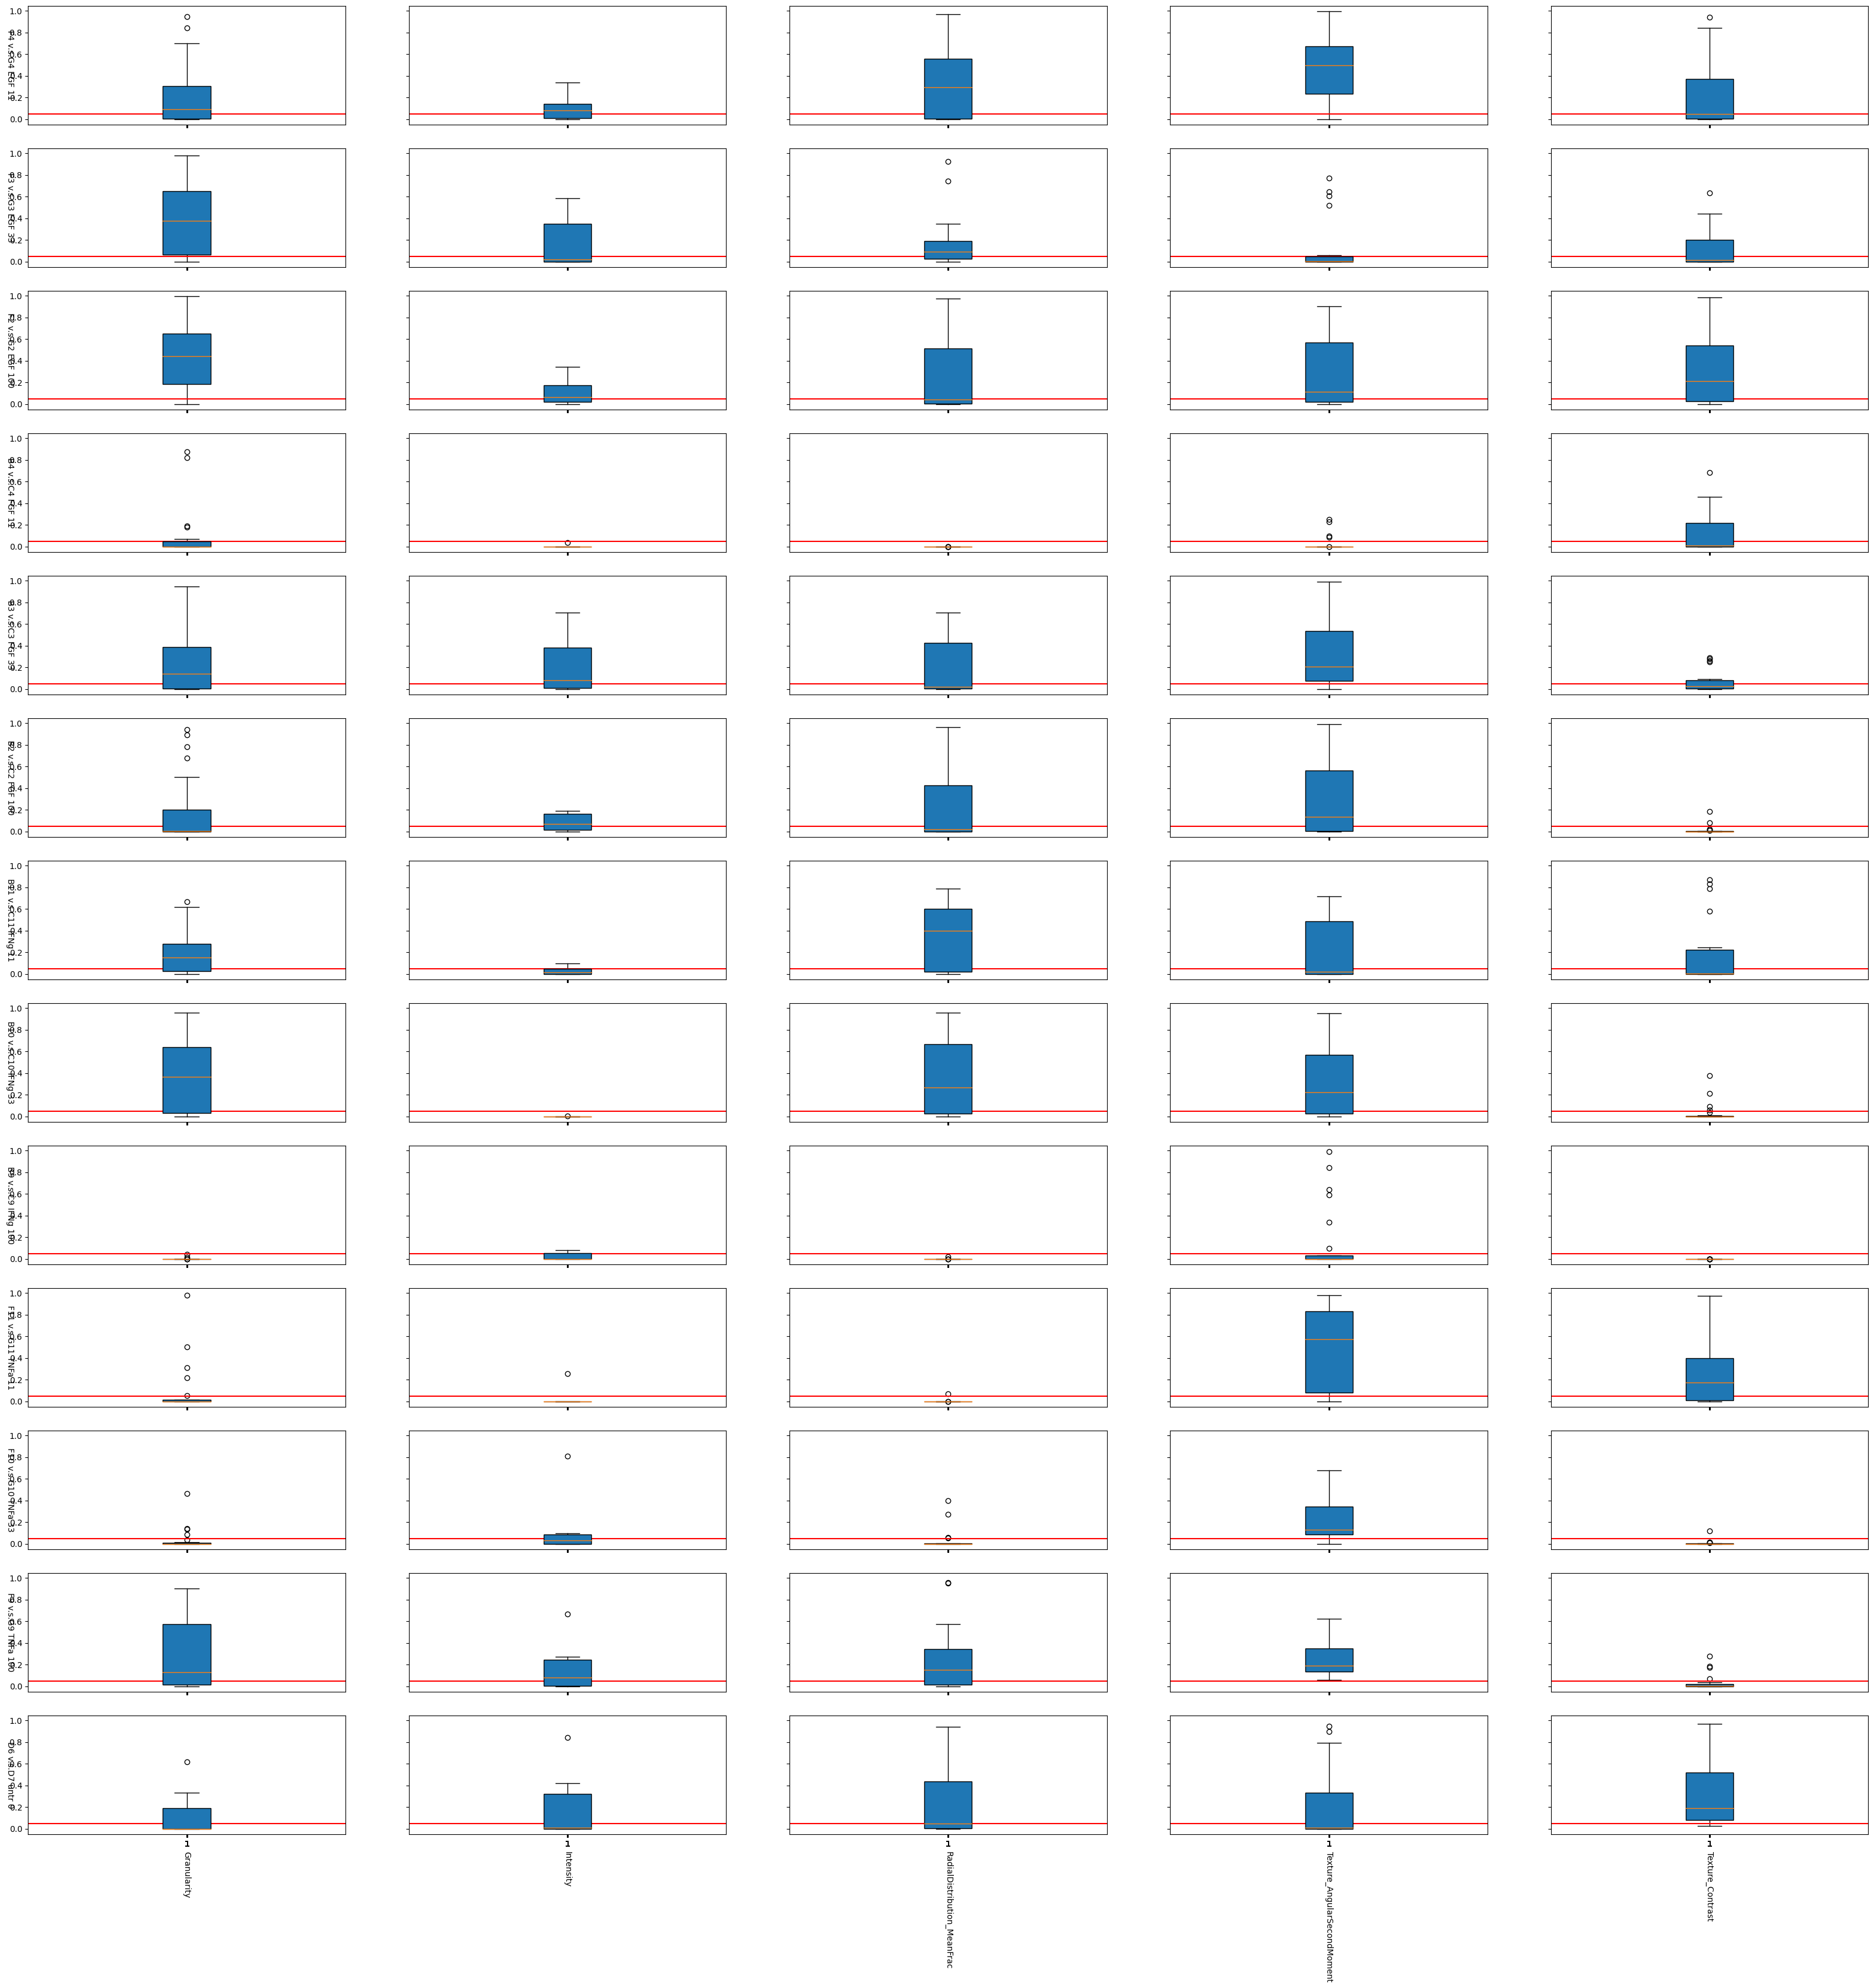

In [11]:
pval_plate1 = perform_ttest(p1, df_p1)
generate_fig(pval_plate1, 'pval_plate1')

C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df_p[df_p['Metadata_Metadata_Cytokine']==currCyto][df_p['Metadata_Metadata_Dose']==currDose]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample1 = sample[df_p['Metadata_Well']==well1][col]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample2 = sample[df_p['Metadata_Well']==well2][col]


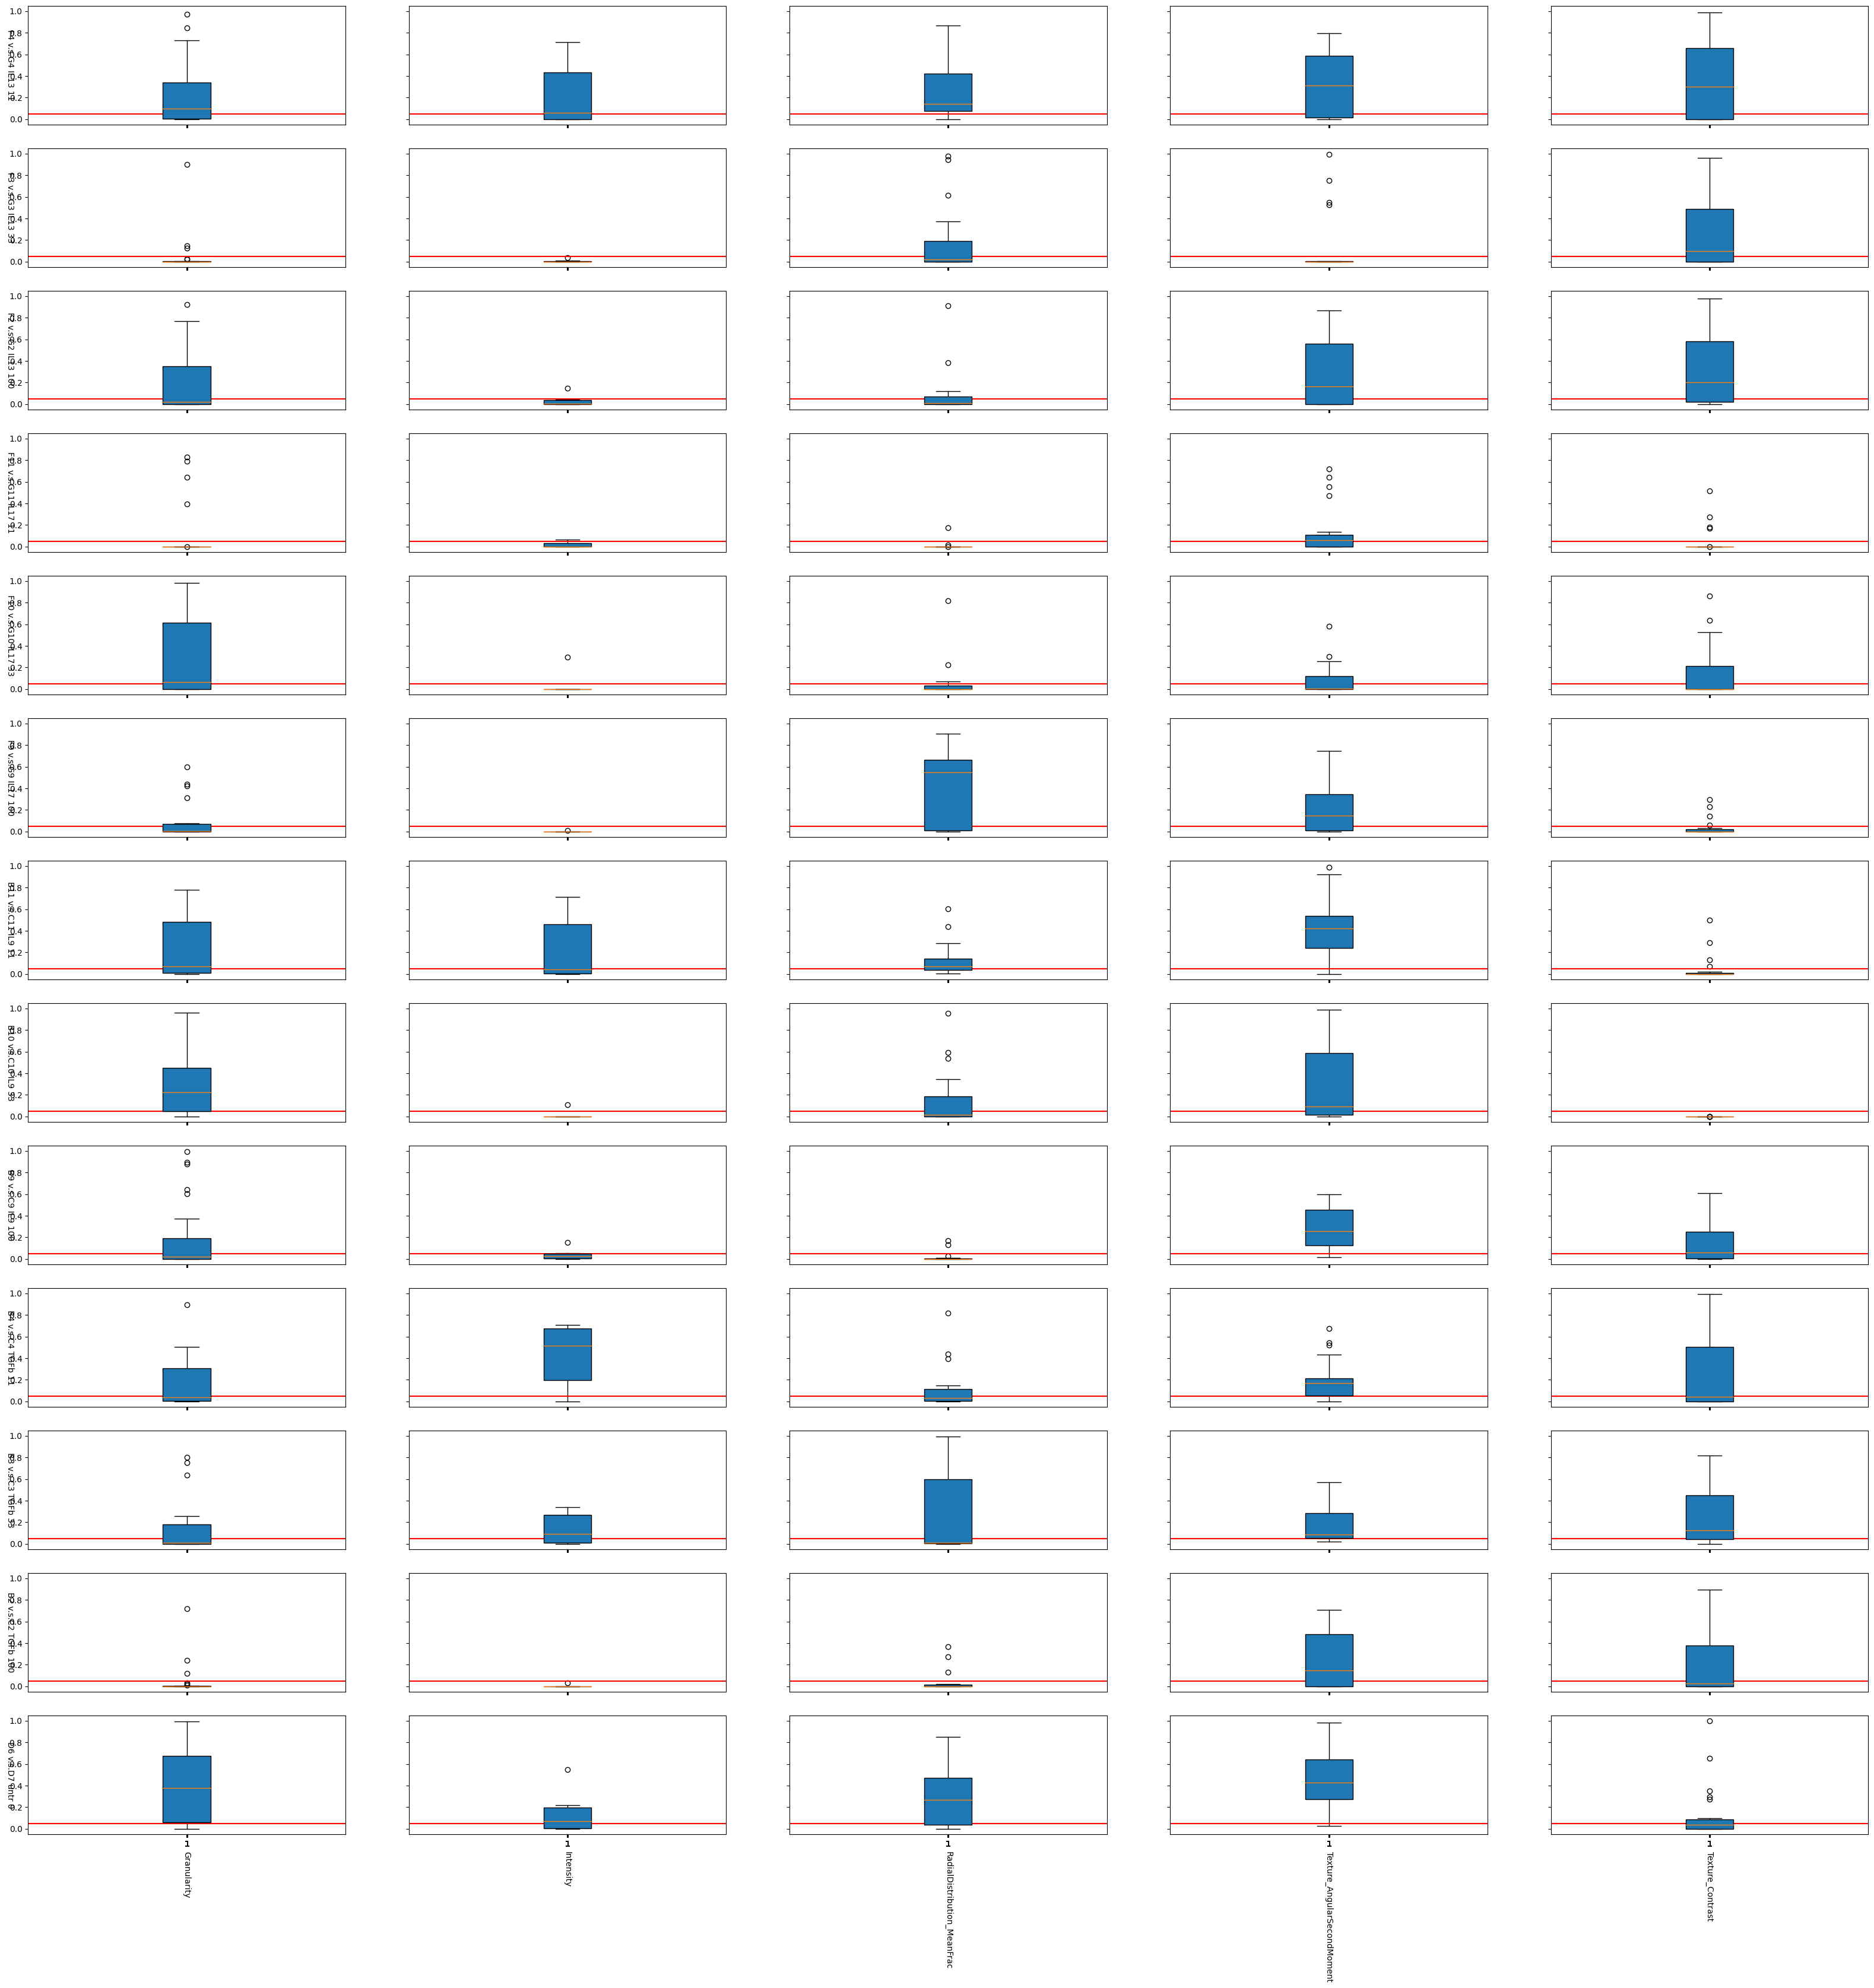

In [12]:
pval_plate2 = perform_ttest(p2, df_p2)
generate_fig(pval_plate2, 'pval_plate2')

C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df_p[df_p['Metadata_Metadata_Cytokine']==currCyto][df_p['Metadata_Metadata_Dose']==currDose]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample1 = sample[df_p['Metadata_Well']==well1][col]
C:\Users\wuron\AppData\Local\Temp\ipykernel_22152\3410422816.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample2 = sample[df_p['Metadata_Well']==well2][col]


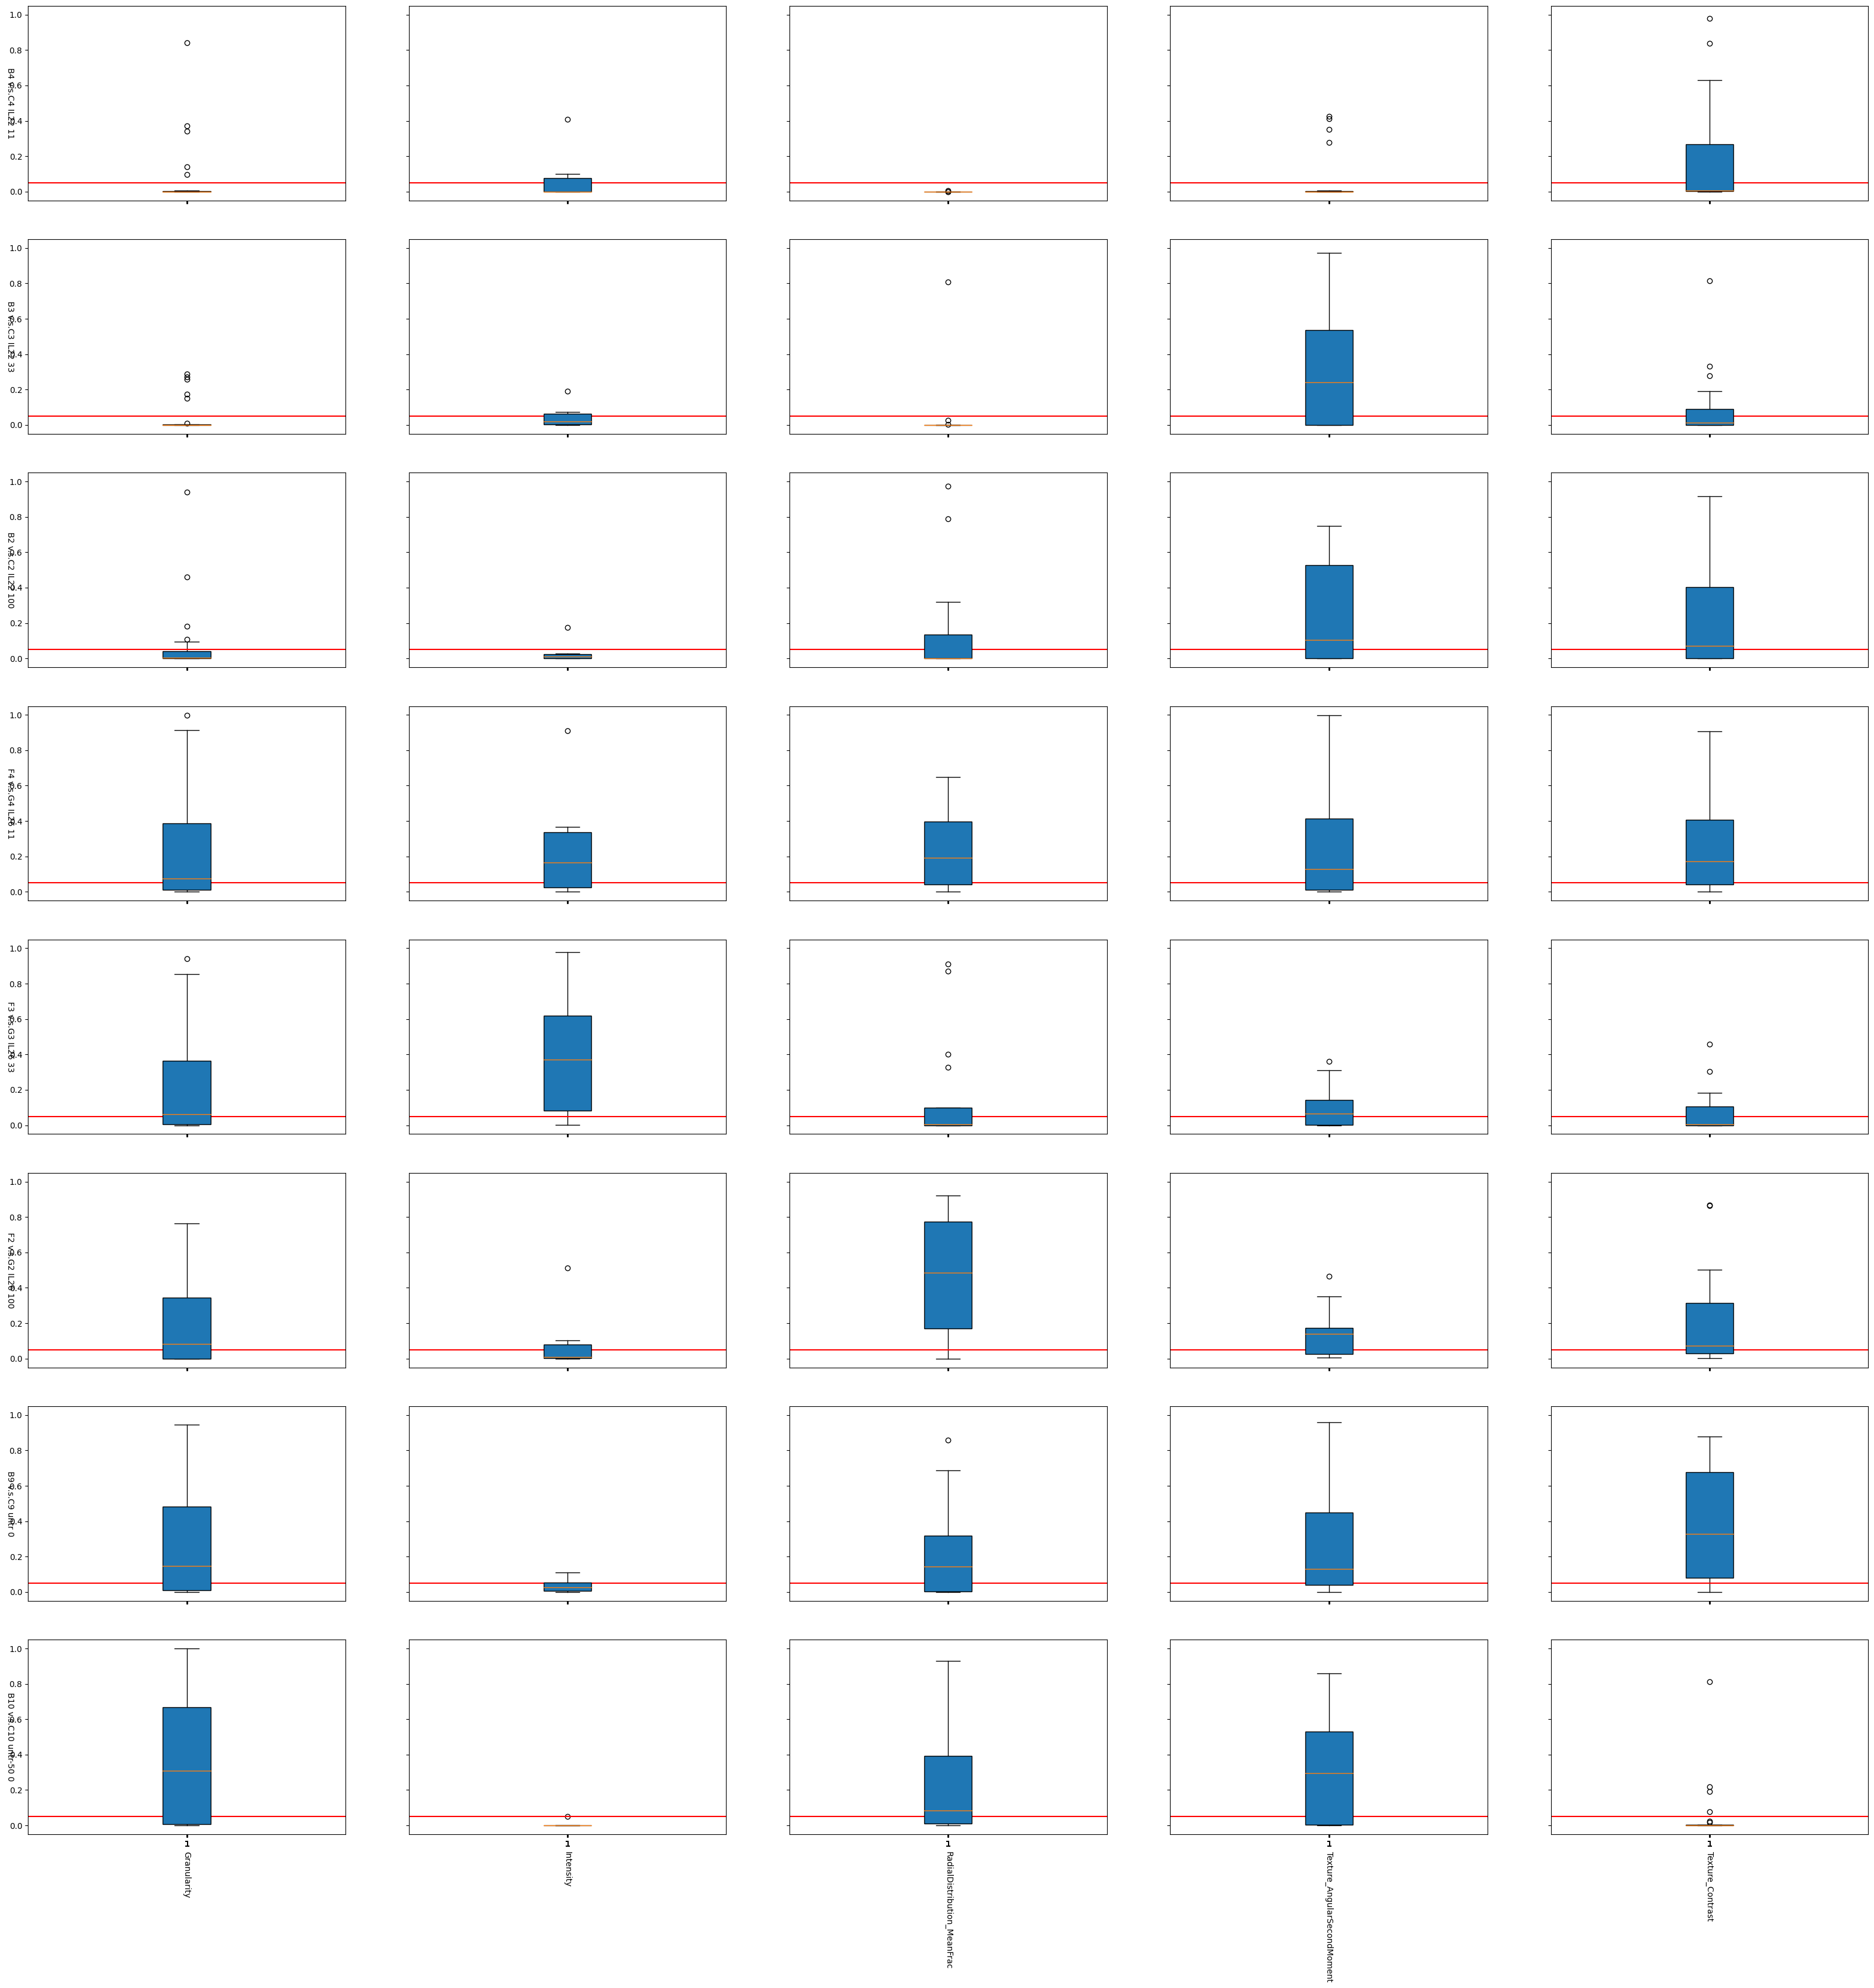

In [13]:
pval_plate3 = perform_ttest(p3, df_p3)
generate_fig(pval_plate3, 'pval_plate3')

In [14]:
rejected_plate1 = pval_plate1.iloc[:,:-2] < 0.05
rejected_plate1 = pd.DataFrame(np.where(rejected_plate1==True, rejected_plate1, 0)).set_index(pval_plate1.index)

In [15]:
def generate_pie(plate):
    
    fig = plt.figure(figsize=(20, 16))
    nrows = 3
    ncols = int(np.ceil(plate.shape[0] / 3))
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows)
    k = 0

    for i in range(nrows):
        for j in range(ncols):
            name = list(plate.index)[k]
            fig.add_subplot(spec[i, j], title=name).pie([plate.iloc[k].sum(), plate.iloc[k].size - plate.iloc[k].sum()], 
                    labels=['Rejected', 'Failed to reject']
                )
            k += 1
            if k == plate.shape[0]:
                return

See from pie charts, for two wells that run the same experiment (same cytokines at the same dosages), the proporton of the experiments to be rejects

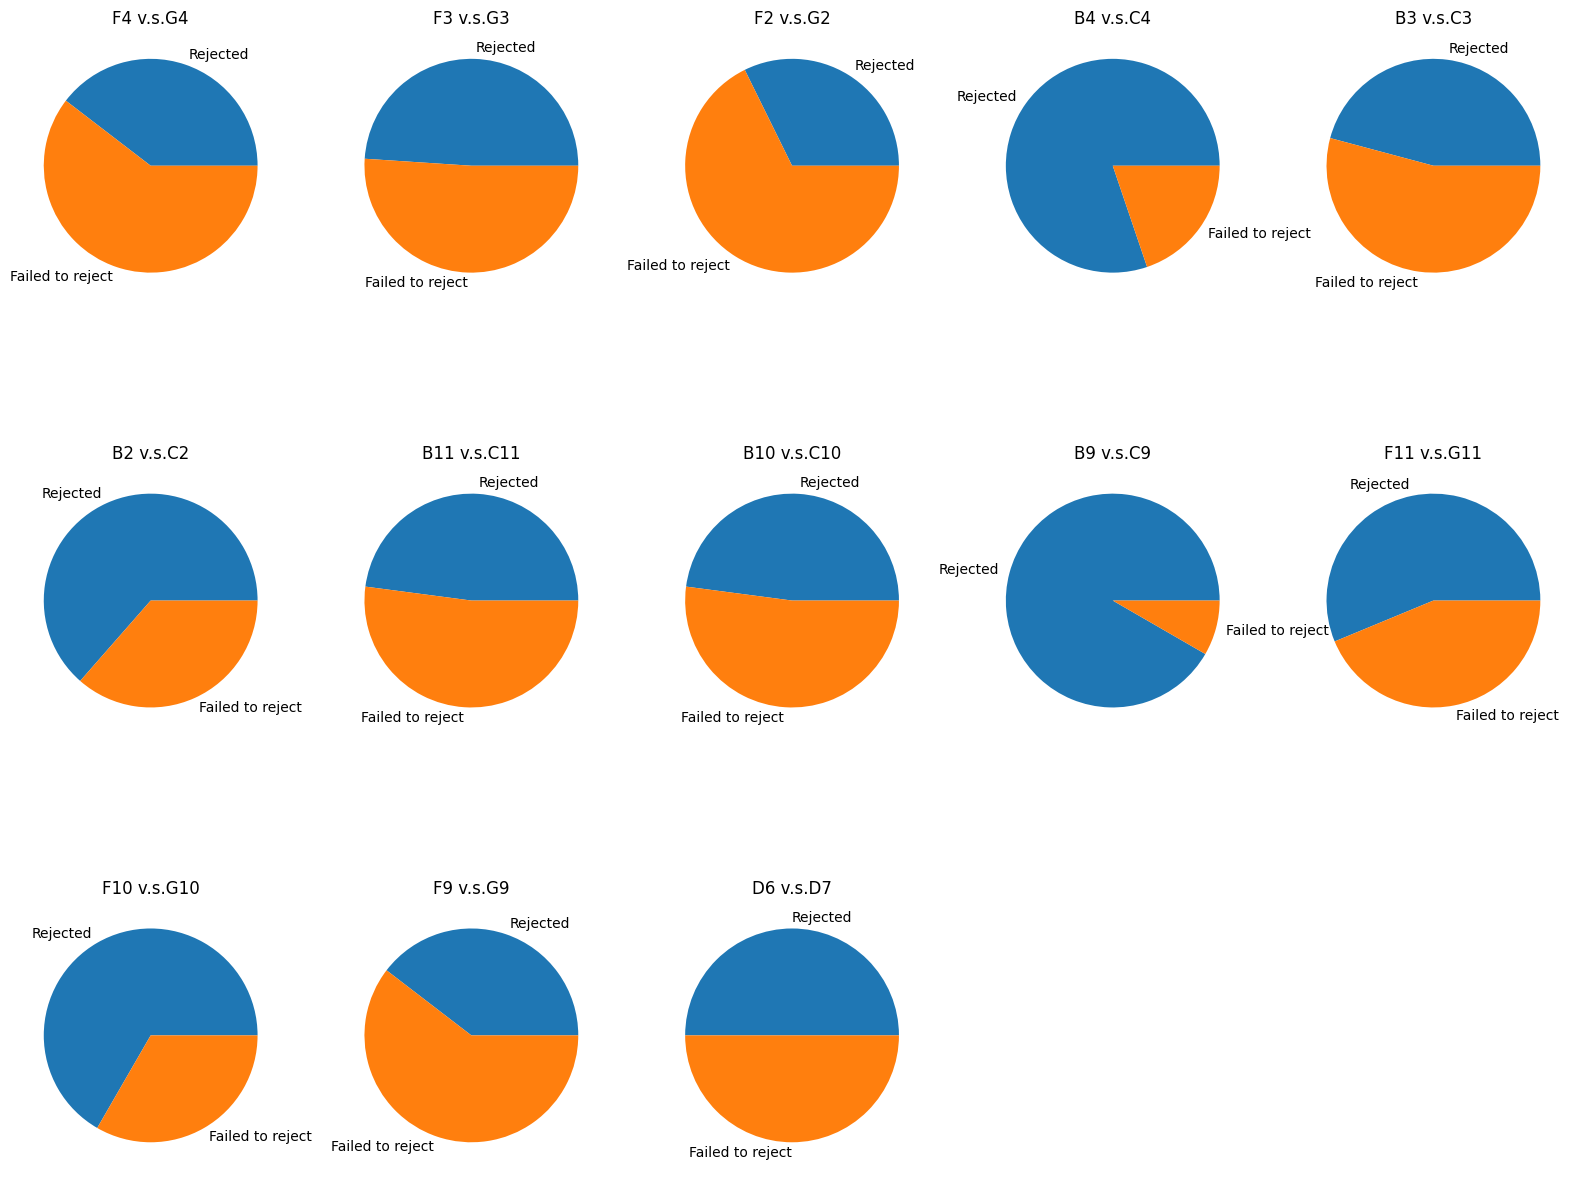

In [16]:
generate_pie(rejected_plate1)

In [17]:
# from matplotlib import colors
# colors_list = ['#FF5733', '#FFC300']
# cmap = colors.ListedColormap(colors_list)
 
# # Plot the heatmap with custom colors and annotations
# plt.imshow(tmp, cmap=cmap, vmin=0, vmax=1, extent=[0, 5, 0, 5])
# # for i in range(5):
# #     for j in range(5):
# #         plt.annotate(str(round(tmp.values[i][j], 2)),\
# #                      xy=(j+0.25, i+0.7),
# #                      ha='center', va='center', color='white')
 
# # Add colorbar
# cbar = plt.colorbar(ticks=[0, 0.5, 1])
# cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
# plt.tight_layout()

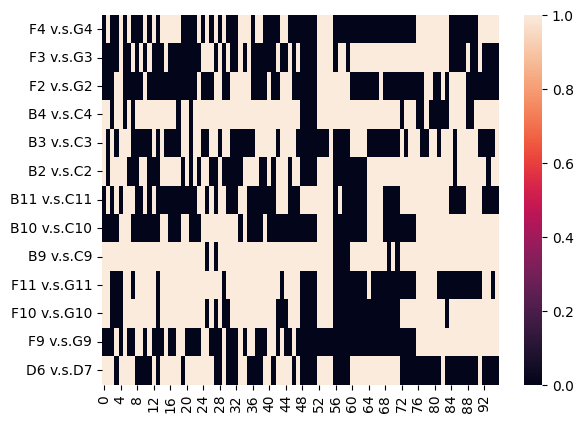

In [18]:
hm = sns.heatmap(data=rejected_plate1)
   
# displaying the plotted heatmap
plt.show()